# Reinforcement Learning

The final method thought of without requiring to worry about non-differentiable qiskit Circuit would be to use reinforcement learning to learn. However, this would be very difficult especially most online tutorials are based on OpenAI Gym and other pre-built libraries available with the pre-built environments. And building own environment, worse still, an environment of qiskit circuit instead of games, is a nightmare. 

Trying our best to implement if possible. 

The code is takend based on: https://github.com/shivaverma/Orbit/blob/master/Paddle/

In [3]:
import qiskit.tools.jupyter
%qiskit_version_table

In [6]:
import qiskit
from qiskit import *
from qiskit.compiler import assemble
from qiskit.visualization import plot_histogram


import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from collections import deque
from tqdm import tqdm

In [7]:
shots = 4000
number = 1
equality = shots / np.power(2, number)

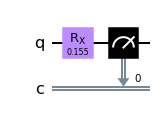

In [8]:
qc = QuantumCircuit(number, number)

rng = np.random.default_rng()

qc.rx(rng.random() * np.pi, 0)

qc.measure(range(number), range(number))
qc.draw("mpl")

In [9]:
target = {"0": int(shots * 0.3), "1": int(shots * 0.7)}
target

{'0': 1200, '1': 2800}

In [108]:
class Qiskit_env():
    
    def __init__(self):
        self.done = False
        self.reward = 0
        self.hit, self.miss = 0, 0
        self.backend = Aer.get_backend('qasm_simulator')
        
        # Setup Qiskit Circuit
        self.previous = shots * 2
        self.qc = QuantumCircuit(number, number)

#         rng = np.random.default_rng()
        
        self.value = rng.random()

#         self.qc.rx(self.value * np.pi, 0)
            
#         self.qc.measure(range(number), range(number))
        
#         circ = transpile(self.qc, self.backend)

#         qobj = assemble(circ, shots=shots)

#         # Run and get counts
#         result = self.backend.run(qobj).result()
#         self.counts = result.get_counts()
        
        self.counts = 0
        self.penalty = 0
        
#         for i in self.counts.keys():
#             self.penalty += target[i] - self.counts[i]
        
#         self.previous = self.penalty
        
    def increase_val(self):
        x = self.value
        
        # Usually will want 2 * np.pi - 0.01 * np.pi but just to make me not confuse. 
        # Plus it would not lead to invalid value, just overshoot and repeat what
        # range we have. So we can savely proceed. 
        
        if x < 2 * np.pi:
            self.value += 0.01
            
            
    def decrease_val(self):
        x = self.value
        
        # Same explanation as before. 
        
        if x > 0:
            self.value -= 0.01
            
            
    def run_frame(self):
        self.penalty = 0
        
        self.qc = QuantumCircuit(number, number)

        
        self.value = rng.random()

        self.qc.rx(self.value * np.pi, 0)
            
        self.qc.measure(range(number), range(number))
        
        circ = transpile(self.qc, self.backend)

        qobj = assemble(circ, shots=shots)

        # Run and get counts
        result = self.backend.run(qobj).result()
        self.counts = result.get_counts()
        
        # Calculate mean  error
        for i in self.counts.keys():
            self.penalty += abs(target[i] - self.counts[i])
        
        # Doing bad job
#         print("Previous: ", self.previous)
#         print("Penalty: ", self.penalty)
#         print("Reward: ", self.reward)
#         print("\n")
        if self.penalty > self.previous:
            self.reward -= 2.5
            
        # Doing good job
        if self.penalty < self.previous:
            self.reward += 3
            
            
        # End of story
        if (self.penalty / shots) < 0.1:
            self.done = True
            
        self.previous = self.penalty
            
    def reset(self):
        return [self.value]
    
    def step(self, action):
        self.reward = 0
        self.done = 0
        
        if action == 0:
            self.increase_val()
            self.reward -= 0.125
            
        if action == 2:
            self.decrease_val()
            self.reward -= 0.125
            
        self.run_frame()
        
        state = [self.value]
        return self.reward, state, self.done
        

In [117]:
env = Qiskit_env()

In [118]:
class DQN:
    """Implementation of Deep Q learning algorithm. """
    
    def __init__(self, action_space, state_space):
        
        self.action_space = action_space
        self.state_space = state_space
        self.epsilon = 1
        self.gamma = 0.95
        self.batch_size = 32  # Not sure how this will affect training. 
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.memory = deque(maxlen=8000)  # Increase if you have larger RAM.
        self.model = self.build_model()
        
        
    def build_model(self):
        model = tf.keras.Sequential()
        model.add(layers.Dense(64, input_shape=(self.state_space,), activation="relu"))
        model.add(layers.Dense(64, activation="relu"))
        model.add(layers.Dense(self.action_space, activation="linear"))
        
        model.compile(loss="mse", optimizer=tf.optimizers.Adam(lr=self.learning_rate))
        
        return model
    
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)
        
        act_values = self.model.predict(state)
        
        return np.argmax(act_values[0])
    
    def replay(self):

        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        targets = rewards + self.gamma*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)

        ind = np.array([i for i in range(self.batch_size)])
#         print(targets_full[[ind], [actions]])
        targets_new = np.empty((self.batch_size, self.action_space))
        targets_new[[ind], [actions]] = targets

        self.model.fit(states, targets_new, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [119]:
def train_dqn(episode):
    loss = []
    
    action_space = 3
    state_space = 1
    max_steps = 1000
    
    agent = DQN(action_space, state_space)
    
    for e in range(episode):
        state = env.reset()
        
        state = np.reshape(state, (1, state_space))
        score = 0
        
        for i in range(max_steps):
            action = agent.act(state)
            reward, next_state, done = env.step(action)
            
            score += reward
            next_state = np.reshape(next_state, (1, state_space))
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.replay()
            
            if done:
                print("episode: {}/{}, score: {}".format(e, episode, score))
                break
                
        loss.append(score)
        
    return loss

In [120]:
ep = 500
loss = train_dqn(ep)

episode: 0/500, score: 5.75
episode: 1/500, score: 4.75
episode: 2/500, score: -0.375
episode: 3/500, score: -7.75
episode: 4/500, score: 6.75
episode: 5/500, score: 2.625
episode: 6/500, score: -0.875
episode: 7/500, score: 16.75
episode: 8/500, score: 7.25
episode: 9/500, score: -2.375
episode: 10/500, score: -2.625
episode: 11/500, score: 0.5
episode: 12/500, score: 2.625
episode: 13/500, score: 3.875
episode: 14/500, score: 4.875
episode: 15/500, score: 6.875
episode: 16/500, score: 0.5
episode: 17/500, score: 0.5
episode: 18/500, score: 0.875
episode: 19/500, score: 0.25
episode: 20/500, score: -2.125
episode: 21/500, score: -2.25
episode: 22/500, score: 0.25
episode: 23/500, score: -0.75
episode: 24/500, score: -13.75
episode: 25/500, score: -7.625
episode: 26/500, score: 0.5
episode: 27/500, score: 4.0
episode: 28/500, score: 3.375
episode: 29/500, score: -5.375
episode: 30/500, score: 1.125
episode: 31/500, score: -6.125
episode: 32/500, score: 3
episode: 33/500, score: 0.375
e

episode: 271/500, score: 0.5
episode: 272/500, score: 4.375
episode: 273/500, score: -7.125
episode: 274/500, score: 10.125
episode: 275/500, score: 13.125
episode: 276/500, score: -5.25
episode: 277/500, score: 5.875
episode: 278/500, score: 6.875
episode: 279/500, score: -0.625
episode: 280/500, score: -2.0
episode: 281/500, score: 6.0
episode: 282/500, score: -4.0
episode: 283/500, score: 4.125
episode: 284/500, score: 22.25
episode: 285/500, score: -0.125
episode: 286/500, score: -6.875
episode: 287/500, score: -2.375
episode: 288/500, score: 6.25
episode: 289/500, score: -2.125
episode: 290/500, score: 4.375
episode: 291/500, score: 7.625
episode: 292/500, score: 0.375
episode: 293/500, score: 28.875
episode: 294/500, score: 3.375
episode: 295/500, score: 3.25
episode: 296/500, score: 12.0
episode: 297/500, score: 4.125
episode: 298/500, score: 10.125
episode: 299/500, score: 0.5
episode: 300/500, score: 4.625
episode: 301/500, score: 11.625
episode: 302/500, score: 0.5
episode: 3

Text(0, 0.5, 'reward')

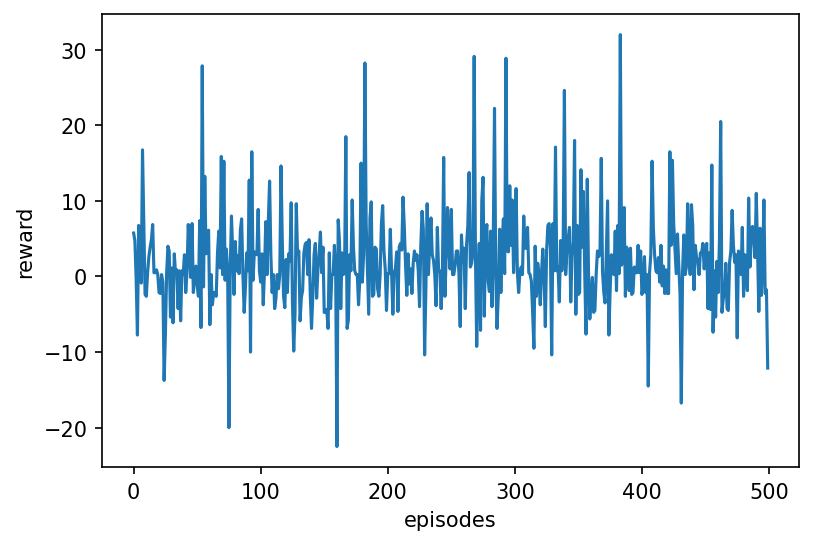

In [121]:
plt.figure(dpi=150)
plt.plot([i for i in range(ep)], loss)
plt.xlabel('episodes')
plt.ylabel('reward')